In [34]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from utils.ml_utils import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterSampler
from tqdm import tqdm

from data_prep import load_features_data

**Load the features data, these are popular trend following features used in prior literature**

In [35]:
feats = load_features_data()
feats.tail()

ret      rVol    1d_ret   1wk_ret    1m_ret  \
date       cluster                                                      
2024-03-15 25        4.383299  0.012166 -0.017495 -0.027395 -0.000720   
           26        2.462165  0.012035 -0.001765  0.009387  0.015050   
           27        2.082460  0.012796 -0.035808 -0.060372 -0.092488   
           28       10.425301  0.012590 -0.011795  0.038502  0.142882   
           29        1.745186  0.012396 -0.012951 -0.018736  0.068956   

                      1Q_ret    6M_ret   12M_ret  feature_1d_ra  \
date       cluster                                                
2024-03-15 25       0.102992  0.072872  0.146811      -1.438042   
           26      -0.022086  0.025308 -0.005369      -0.146644   
           27      -0.037253  0.112426  0.139470      -2.798448   
           28       0.110394  0.209679  0.370151      -0.936814   
           29       0.007108 -0.013731 -0.046507      -1.044764   

                    feature_1wk_ra  ...  lag5_feature_MACD_short  \
date       cluster                  ...                            
2024-03-15 25            -1.007008  ...                 0.398363   
           26             0.348834  ...                -0.199871   
           27            -2.110060  ...                -0.032563   
           28             1.367633  ...                 0.523603   
           29            -0.675943  ...                 0.626469   

                    lag5_feature_MACD_medium  lag5_feature_MACD_long  \
date       cluster                                                     
2024-03-15 25                       0.585645                0.664800   
           26                      -0.179508                0.128255   
           27                       0.246765                0.754907   
           28                       0.554301                0.698447   
           29                       0.518373                0.183227   

                    lag5_feature_skew6m  lag5_feature_skew12m  \
date       cluster                                              
2024-03-15 25                 -0.222085              0.386809   
           26                 -0.217538              0.392190   
           27                 -0.231616              0.380269   
           28                 -0.231386              0.365261   
           29                 -0.230371              0.372743   

                    lag5_feature_kurt6m  lag5_feature_kurt12m  fwd_ret1d  \
date       cluster                                                         
2024-03-15 25                  0.580919              2.809109        NaN   
           26                  0.566987              2.789701        NaN   
           27                  0.525654              2.751046        NaN   
           28                  0.518548              2.752472        NaN   
           29                  0.519866              2.848368        NaN   

                    target  targetBin  
date       cluster                     
2024-03-15 25          NaN        NaN  
           26          NaN        NaN  
           27          NaN        NaN  
           28          NaN        NaN  
           29          NaN        NaN  

[5 rows x 89 columns]

**Extract the predictive features and target which is one day forward risk adjusted returns - drop na on this subset**

In [36]:
features = [f for f in feats.columns if f.startswith("feature")]
lag_feats = [f for f in feats.columns if f.startswith("lag")]
target = ["target"]

all_feats = features + target + lag_feats
feats.dropna(subset=all_feats, inplace=True)
feats = feats[all_feats]

print("Shape of features", feats.shape)

Shape of features (166530, 79)


**Break out X and y and set up cross-validation**

In [37]:
X = feats[all_feats].copy()

baseRF = RandomForestRegressor(max_depth=5, 
                               n_estimators=1000,
                               max_features=int(1),
                               n_jobs=-3)

# simple-grid
grid = {'n_estimators': np.arange(100, 1000, 100),
        'max_depth': [3, 6, 9],
        'max_features': [int(1), 'sqrt'],
        'min_weight_fraction_leaf': np.arange(0.0, 0.05, 0.005)}

params = ParameterSampler(n_iter=25, param_distributions=grid)


**Form the training loop, here we train on 3 year expanding windows, using 90% of each split for training and 10% for tuning hyper-parameters, we then use the same model to forecast forward 3-years before re-training again.**

In [38]:
predictions = []
scores = []
for train, test in tqdm(get_cv_splits(X, split_length=252*3)):
    # break out X and y train, test
    X_train, y_train = train[features], train[target] 
    X_test, y_test = test[features], test[target]

    # hyper-param loop
    X_train2, X_val, y_train2, y_val = train_val_split(X_train, y_train)
    print(X_train2.shape, X_val.shape)

    # inner loop for parameter tuning
    gscv_scores = {'scores': [], 'grid':[]}
    for k, p in enumerate(params):
        model = RandomForestRegressor(**p)
        model.n_jobs=-1
        model.fit(X_train2, y_train2.values.reshape(y_train2.shape[0], ))
        _pred = model.predict(X_val)
        _score = mean_squared_error(y_val, _pred)
        gscv_scores['scores'].append(_score)
        gscv_scores['grid'].append(p)
        print(f'Iter: {k}: Score: {_score}')

    # now fit the best model
    best_model = pd.DataFrame(gscv_scores).sort_values(by='scores').head(1)['grid'].values[0]
    print(best_model)
    best_model = RandomForestRegressor(**best_model)
    best_model.n_jobs=-1
    best_model.fit(X_train, y_train.values.reshape(y_train.shape[0], ))
    preds = best_model.predict(X_test)

    # append the predictions
    predictions.append(pd.Series(index=y_test.index, data=preds))

    # score
    scores.append(mean_squared_error(y_test, preds))

0it [00:00, ?it/s]

7
(20439, 13) (2250, 13)
Iter: 0: Score: 1.7076212604160506
Iter: 1: Score: 1.6999246113972242
Iter: 2: Score: 1.695660420096738
Iter: 3: Score: 1.6921421377741996
Iter: 4: Score: 1.6972248515973114
Iter: 5: Score: 1.7096650068624888
Iter: 6: Score: 1.7123144623682072
Iter: 7: Score: 1.699196885014563
Iter: 8: Score: 1.7013950950836785
Iter: 9: Score: 1.6879553630344764
Iter: 10: Score: 1.7038937138358075
Iter: 11: Score: 1.6935225124391229
Iter: 12: Score: 1.6946237506160595
Iter: 13: Score: 1.687679488161436
Iter: 14: Score: 1.69473532616149
Iter: 15: Score: 1.7032375778179287
Iter: 16: Score: 1.6872518208633778
Iter: 17: Score: 1.7028547075210312
Iter: 18: Score: 1.700631655456489
Iter: 19: Score: 1.6918228637831865
Iter: 20: Score: 1.6972488115467714
Iter: 21: Score: 1.6858081048835079
Iter: 22: Score: 1.7022865291115024
Iter: 23: Score: 1.687667223885381


1it [00:35, 35.04s/it]

Iter: 24: Score: 1.7029605944183843
{'n_estimators': 100, 'min_weight_fraction_leaf': 0.04, 'max_features': 1, 'max_depth': 3}
(40878, 13) (4530, 13)
Iter: 0: Score: 1.844988859304403
Iter: 1: Score: 1.8678687713406066
Iter: 2: Score: 1.8451978797169792
Iter: 3: Score: 1.8588102527246724
Iter: 4: Score: 1.8644230052890791
Iter: 5: Score: 1.8471122302788199
Iter: 6: Score: 1.8670196987371002
Iter: 7: Score: 1.8444769447491207
Iter: 8: Score: 1.8497810015713643
Iter: 9: Score: 1.8474655588628948
Iter: 10: Score: 1.8510902638042042
Iter: 11: Score: 1.8518566558243488
Iter: 12: Score: 1.8541196503992605
Iter: 13: Score: 1.850342769690807
Iter: 14: Score: 1.8513577485955177
Iter: 15: Score: 1.8504802021525948
Iter: 16: Score: 1.8500935711784583
Iter: 17: Score: 1.855014431359565
Iter: 18: Score: 1.8540565135827778
Iter: 19: Score: 1.8460596547443586
Iter: 20: Score: 1.8558416565432199
Iter: 21: Score: 1.8481584440113594
Iter: 22: Score: 1.8667034318166478
Iter: 23: Score: 1.8579456068124358

2it [01:55, 61.89s/it]

(61290, 13) (6810, 13)
Iter: 0: Score: 2.082765391919954
Iter: 1: Score: 2.083172786252606
Iter: 2: Score: 2.082384269287987
Iter: 3: Score: 2.0834890418386323
Iter: 4: Score: 2.0832302654600627
Iter: 5: Score: 2.0828428883651684
Iter: 6: Score: 2.0829080694839375
Iter: 7: Score: 2.0840560460570727
Iter: 8: Score: 2.240762807583421
Iter: 9: Score: 2.0871508673774413
Iter: 10: Score: 2.0812583633509005
Iter: 11: Score: 2.2328660439443055
Iter: 12: Score: 2.080457789238336
Iter: 13: Score: 2.0879385699181965
Iter: 14: Score: 2.0835693685005756
Iter: 15: Score: 2.0879501325697842
Iter: 16: Score: 2.0942766136445696
Iter: 17: Score: 2.102576087079022
Iter: 18: Score: 2.085414245054844
Iter: 19: Score: 2.0842326140825587
Iter: 20: Score: 2.099624490738531
Iter: 21: Score: 2.22276633677418
Iter: 22: Score: 2.0813489811807693
Iter: 23: Score: 2.0847520746495256
Iter: 24: Score: 2.0920299190748364
{'n_estimators': 300, 'min_weight_fraction_leaf': 0.005, 'max_features': 1, 'max_depth': 3}


3it [03:29, 76.51s/it]

(81702, 13) (9060, 13)
Iter: 0: Score: 1.6401777033966543
Iter: 1: Score: 1.6442472222606648
Iter: 2: Score: 1.641263002773385
Iter: 3: Score: 1.6443666581485208
Iter: 4: Score: 1.6417044827288338
Iter: 5: Score: 1.6402961442660735
Iter: 6: Score: 1.6402440837706393
Iter: 7: Score: 1.6435432054454946
Iter: 8: Score: 1.6407338100450362
Iter: 9: Score: 1.6398367945074364
Iter: 10: Score: 1.6436470190868087
Iter: 11: Score: 1.6629491913045245
Iter: 12: Score: 1.6418988640290653
Iter: 13: Score: 1.6429617799320408
Iter: 14: Score: 1.6410353034146976
Iter: 15: Score: 1.640489838212951
Iter: 16: Score: 1.6435199006270982
Iter: 17: Score: 1.6398369601672198
Iter: 18: Score: 1.640389967507595
Iter: 19: Score: 1.6407008680474577
Iter: 20: Score: 1.6394912091652951
Iter: 21: Score: 1.6428831511416289
Iter: 22: Score: 1.6433871868764511
Iter: 23: Score: 1.6382223495835664
Iter: 24: Score: 1.640892898150301
{'n_estimators': 100, 'min_weight_fraction_leaf': 0.045, 'max_features': 1, 'max_depth': 3}

4it [04:44, 76.00s/it]

(102114, 13) (11340, 13)
Iter: 0: Score: 1.499950990603956
Iter: 1: Score: 1.498221806085416
Iter: 2: Score: 1.500309836715176
Iter: 3: Score: 1.4990976655411037
Iter: 4: Score: 1.5012264213211302
Iter: 5: Score: 1.4986374196238936
Iter: 6: Score: 1.5011074926810692
Iter: 7: Score: 1.4984478620148112
Iter: 8: Score: 1.4987864013291874
Iter: 9: Score: 1.499899902566967
Iter: 10: Score: 1.4986883997896145
Iter: 11: Score: 1.499181766966865
Iter: 12: Score: 1.5009323670477952
Iter: 13: Score: 1.4992732980512282
Iter: 14: Score: 1.5014027217300858
Iter: 15: Score: 1.499055059862965
Iter: 16: Score: 1.4990708068859666
Iter: 17: Score: 1.4982892873584446
Iter: 18: Score: 1.4990000885130512
Iter: 19: Score: 1.5000071740515204
Iter: 20: Score: 1.4988098727828376
Iter: 21: Score: 1.4985976373350778
Iter: 22: Score: 1.4986927741982616
Iter: 23: Score: 1.499092348960328
Iter: 24: Score: 1.500168066883584
{'n_estimators': 200, 'min_weight_fraction_leaf': 0.01, 'max_features': 1, 'max_depth': 3}


5it [07:23, 105.82s/it]

(122526, 13) (13590, 13)
Iter: 0: Score: 1.546623979809437
Iter: 1: Score: 1.5439421383229606
Iter: 2: Score: 1.5469463597610749
Iter: 3: Score: 1.5447279642994112
Iter: 4: Score: 1.5453789149298058
Iter: 5: Score: 1.5468594317164281
Iter: 6: Score: 1.5465941799252136
Iter: 7: Score: 1.5469006790949722
Iter: 8: Score: 1.547986806241072
Iter: 9: Score: 1.548232577590718
Iter: 10: Score: 1.545300442998237
Iter: 11: Score: 1.5461761244777286
Iter: 12: Score: 1.5465052738459057
Iter: 13: Score: 1.546430231762374
Iter: 14: Score: 1.5472411179309002
Iter: 15: Score: 1.547855225837436
Iter: 16: Score: 1.5472906379997222
Iter: 17: Score: 1.5454857624532408
Iter: 18: Score: 1.5459993059676573
Iter: 19: Score: 1.546386889804564
Iter: 20: Score: 1.545838499161958
Iter: 21: Score: 1.5435271277378353
Iter: 22: Score: 1.5461197160667883
Iter: 23: Score: 1.5469236450704782
Iter: 24: Score: 1.545143259332172
{'n_estimators': 500, 'min_weight_fraction_leaf': 0.0, 'max_features': 1, 'max_depth': 3}


6it [09:58, 122.68s/it]

(142938, 13) (15870, 13)
Iter: 0: Score: 1.4977110931418638
Iter: 1: Score: 1.4995790444047001
Iter: 2: Score: 1.4980311884825401
Iter: 3: Score: 1.4974560530570111
Iter: 4: Score: 1.497913165798235
Iter: 5: Score: 1.4985514546978718
Iter: 6: Score: 1.5004561113392436
Iter: 7: Score: 1.498796516689275
Iter: 8: Score: 1.49902297508479
Iter: 9: Score: 1.4979417930956516
Iter: 10: Score: 1.4985581886010946
Iter: 11: Score: 1.4984249855865224
Iter: 12: Score: 1.4982747805441994
Iter: 13: Score: 1.4999349158155926
Iter: 14: Score: 1.4985957117221596
Iter: 15: Score: 1.4979022627264706
Iter: 16: Score: 1.4984202150905535
Iter: 17: Score: 1.5114103523177513
Iter: 18: Score: 1.4987405954226836
Iter: 19: Score: 1.4987798301012323
Iter: 20: Score: 1.4993706224155063
Iter: 21: Score: 1.4981360194311075
Iter: 22: Score: 1.4979515554431995
Iter: 23: Score: 1.5021611041757166
Iter: 24: Score: 1.503435284629971
{'n_estimators': 900, 'min_weight_fraction_leaf': 0.045, 'max_features': 'sqrt', 'max_dept

7it [14:14, 122.02s/it]


**Now we join the forecasted returns back into the returns df, we can create a simple portfolio construction strategy where we equal weight the top half, top quartile of the clusters. We can also create a long short strategy that goes long the top quartile of forecasting cluster returns and short the bottom quartile, for a market neutral portfolio.**

In [45]:
all_feats = load_features_data()
all_feats.tail()

predictions = predictions.join(all_feats[['1d_ret']])

In [52]:
predictions['signal_quintile']=predictions.groupby(by='date')['predictions'].apply(lambda x: pd.qcut(x, 5, labels=False)).droplevel(0)


In [54]:
predictions['signal_quintiles_shift'] = predictions.groupby(by='cluster')['signal_quintile'].shift(1)


**Plot some strategy returns**

<Axes: title={'center': 'Forecasted by Cluster Quintile'}, xlabel='date'>

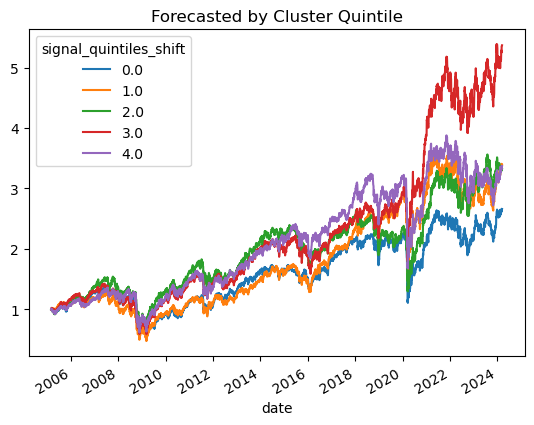

In [61]:
(1+predictions.groupby(by=['date', 'signal_quintiles_shift'])['1d_ret'].mean().unstack()).cumprod().plot(title="Forecasted by Cluster Quintile")